In [ ]:
import sys
sys.path.append("..")
# Reproducing https://www.science.org/doi/10.1126/sciadv.adh8498
pw = (7,7) # Plane waves along x, y directions
a    =  1.220         # um pitch of the PhC
r    =  0.502 / a     # nat radius of the holes
h_phc =  0.320 / a     # nat, depth of the slab
h_sin = 0.120/a
h_intrl = 0.550 / a
esin = 2.0**2
ehole = 1.0**2        # epsilon of SiN
from khepri import Crystal, Drawing
cl = Crystal(pw, lattice= "square", epsi=1.0, epse=1.0) # Optional: incidence and emergence media
d = Drawing(shape= (128,128), epsilon_background=esin, lattice=cl.lattice)
d.disc(xy=(0, 0), radius= r, epsilon= ehole)

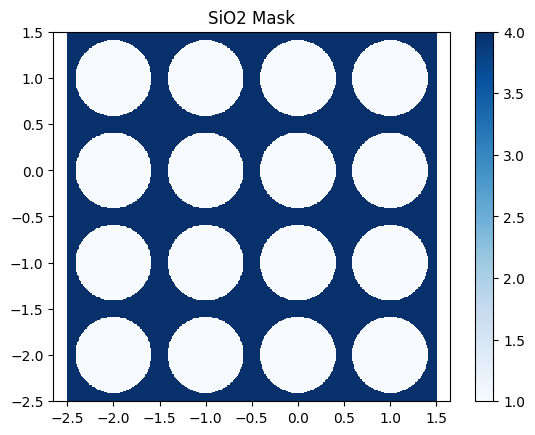

In [20]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
a1, a2 = cl.lattice # Extract lattice vector from the cl object : the "hexagonal"
for (i, j) in product(range(-2,2), range(-2, 2)):
    # Tiling of the unit cell along a1, a2
    im = ax.pcolormesh(i*a1[0]+j*a2[0] + d.X, i*a1[1]+j*a2[1] +d.Y, d.canvas(), cmap="Blues")
ax.axis("equal")
ax.set_title("SiO2 Mask")
plt.colorbar(im)

In [21]:
from tqdm import tqdm

cl.add_layer_pixmap(name="A", epsilon=d.canvas(), depth=h_phc)
cl.add_layer_uniform(name='B', epsilon=esin, depth= h_sin)
cl.add_layer_uniform(name='C', epsilon=ehole, depth= h_intrl)
cl.add_layer_pixmap(name="D", epsilon=d.canvas(), depth=h_phc)
cl.add_layer_uniform(name='E', epsilon=esin, depth= h_sin)
device = ["A", 'B', 'C', 'D', 'E']
cl.set_device(device, fields_mask=False)

# --- Frequency range ---
c = 299792458
fmin = 180e12 / (c / (a * 1e-6))
fmax = 210e12 / (c / (a * 1e-6))
nfs, nks = 200, 200

freq_norm = np.linspace(fmin, fmax, nfs)

# --- k-path ---
Gamma = np.array([0, 0])
M = np.array([-0.3, -0.3])
X = np.array([0.3, 0])

M_to_Gamma = np.linspace(M, Gamma, nks, endpoint=False)
Gamma_to_X = np.linspace(Gamma, X, nks)

# total = 256 points
k_path = np.vstack([M_to_Gamma, Gamma_to_X])
k_path = 2*np.pi * k_path

nk = k_path.shape[0]  # = 256

# --- allocate storage ---
data = np.zeros((nk, nfs))

# --- main loop ---
for k_index, (kx,ky) in tqdm(enumerate(k_path), desc = 'Progress'):
    for f_index, f in enumerate(freq_norm):
        cl.set_source(wavelength=1/f, te=1.0, tm=1.0, kp=(kx, ky)) 
        cl.solve() 
        R, T = cl.poynting_flux_end(only_total=True)
        data[k_index, f_index] = np.abs(T)**2

Progress: 400it [1:31:34, 13.74s/it]


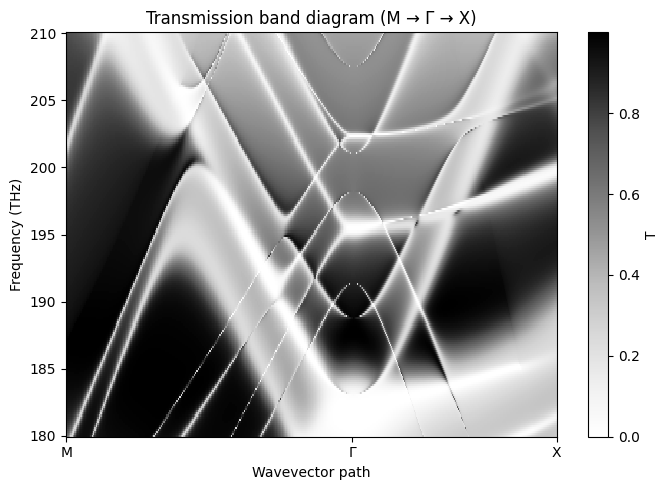

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Build cumulative distance along k-path
dk = np.linalg.norm(np.diff(k_path, axis=0), axis=1)
dist = np.concatenate(([0], np.cumsum(dk)))
dist /= dist[-1]

# freq_THz must correspond to your fmin, fmax (in THz)
freq_THz = np.linspace(180, 210, nfs)

# Plot
plt.figure(figsize=(7,5))

plt.pcolormesh(
    dist,
    freq_THz,   # vertical axis = THz!
    data.T,     # (freq × k)
    shading='auto',
    cmap='Greys'
)

plt.ylabel("Frequency (THz)")
plt.xlabel("Wavevector path")
plt.title("Transmission band diagram (M → Γ → X)")
plt.colorbar(label="T")

# Symmetry point labels
xticks = [0, dist[len(M_to_Gamma)-1], dist[-1]]
plt.xticks(xticks, ["M", "Γ", "X"])

plt.tight_layout()
plt.show()
